In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

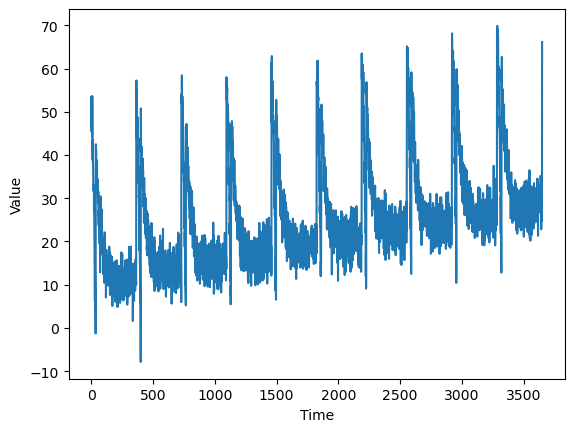

In [7]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),# YOUR CODE HERE),
                      input_shape=[None]),

  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),

  tf.keras.layers.Lambda(lambda x: x * 10.0)# YOUR CODE HERE)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
94/94 [==============================] - 8s 29ms/step - loss: 18.0726 - mae: 18.5725 - lr: 1.0000e-08
Epoch 2/100
94/94 [==============================] - 2s 17ms/step - loss: 18.0407 - mae: 18.5406 - lr: 1.1220e-08
Epoch 3/100
94/94 [==============================] - 2s 18ms/step - loss: 18.0046 - mae: 18.5045 - lr: 1.2589e-08
Epoch 4/100
94/94 [==============================] - 2s 18ms/step - loss: 17.9641 - mae: 18.4640 - lr: 1.4125e-08
Epoch 5/100
94/94 [==============================] - 2s 19ms/step - loss: 17.9187 - mae: 18.4186 - lr: 1.5849e-08
Epoch 6/100
94/94 [==============================] - 2s 20ms/step - loss: 17.8678 - mae: 18.3677 - lr: 1.7783e-08
Epoch 7/100
94/94 [==============================] - 2s 19ms/step - loss: 17.8107 - mae: 18.3106 - lr: 1.9953e-08
Epoch 8/100
94/94 [==============================] - 2s 20ms/step - loss: 17.7468 - mae: 18.2466 - lr: 2.2387e-08
Epoch 9/100
94/94 [==============================] - 2s 19ms/step - loss: 17.6751 - mae:

94/94 [==============================] - 2s 19ms/step - loss: 3.4134 - mae: 3.8784 - lr: 3.9811e-05
Epoch 74/100
94/94 [==============================] - 2s 19ms/step - loss: 3.2758 - mae: 3.7401 - lr: 4.4668e-05
Epoch 75/100
94/94 [==============================] - 2s 19ms/step - loss: 3.1877 - mae: 3.6528 - lr: 5.0119e-05
Epoch 76/100
94/94 [==============================] - 2s 19ms/step - loss: 3.1139 - mae: 3.5745 - lr: 5.6234e-05
Epoch 77/100
94/94 [==============================] - 2s 19ms/step - loss: 3.1587 - mae: 3.6246 - lr: 6.3096e-05
Epoch 78/100
94/94 [==============================] - 2s 19ms/step - loss: 3.0573 - mae: 3.5218 - lr: 7.0795e-05
Epoch 79/100
94/94 [==============================] - 2s 19ms/step - loss: 3.1026 - mae: 3.5690 - lr: 7.9433e-05
Epoch 80/100
94/94 [==============================] - 2s 19ms/step - loss: 3.2400 - mae: 3.7074 - lr: 8.9125e-05
Epoch 81/100
94/94 [==============================] - 2s 19ms/step - loss: 2.9731 - mae: 3.4359 - lr: 1.0000e

(1e-08, 0.0001, 0.0, 30.0)

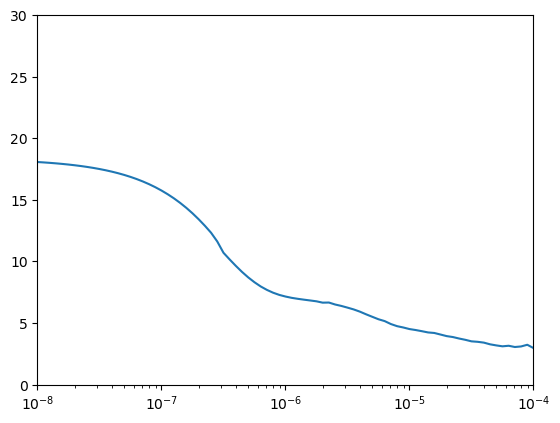

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [11]:

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),# YOUR CODE HERE),
                      input_shape=[None]),

  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),

  tf.keras.layers.Lambda(lambda x: x * 100.0)# YOUR CODE HERE)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9),metrics=["mae"])# PUT YOUR LEARNING RATE HERE#, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=1)

# FIND A MODEL AND A LR THAT TRAINS TO AN MAE < 3  

Epoch 1/500
94/94 [==============================] - 7s 17ms/step - loss: 221.4269 - mae: 9.3217
Epoch 2/500
94/94 [==============================] - 2s 17ms/step - loss: 37.5722 - mae: 4.1694
Epoch 3/500
94/94 [==============================] - 2s 18ms/step - loss: 29.6062 - mae: 3.6498
Epoch 4/500
94/94 [==============================] - 2s 17ms/step - loss: 35.4059 - mae: 4.2322
Epoch 5/500
94/94 [==============================] - 2s 18ms/step - loss: 28.7809 - mae: 3.6559
Epoch 6/500
94/94 [==============================] - 2s 18ms/step - loss: 27.2853 - mae: 3.5390
Epoch 7/500
94/94 [==============================] - 2s 17ms/step - loss: 35.6021 - mae: 4.2432
Epoch 8/500
94/94 [==============================] - 2s 17ms/step - loss: 28.1848 - mae: 3.6150
Epoch 9/500
94/94 [==============================] - 2s 17ms/step - loss: 30.8521 - mae: 3.9312
Epoch 10/500
94/94 [==============================] - 2s 17ms/step - loss: 27.9392 - mae: 3.6255
Epoch 11/500
94/94 [==================

94/94 [==============================] - 2s 20ms/step - loss: 20.9955 - mae: 3.0729
Epoch 86/500
94/94 [==============================] - 2s 18ms/step - loss: 21.6199 - mae: 3.0966
Epoch 87/500
94/94 [==============================] - 2s 19ms/step - loss: 21.9501 - mae: 3.2030
Epoch 88/500
94/94 [==============================] - 2s 21ms/step - loss: 20.6257 - mae: 3.0325
Epoch 89/500
94/94 [==============================] - 2s 25ms/step - loss: 21.2037 - mae: 3.0787
Epoch 90/500
94/94 [==============================] - 2s 22ms/step - loss: 20.5220 - mae: 3.0338
Epoch 91/500
94/94 [==============================] - 2s 21ms/step - loss: 21.0945 - mae: 3.1024
Epoch 92/500
94/94 [==============================] - 2s 20ms/step - loss: 21.9669 - mae: 3.1477
Epoch 93/500
94/94 [==============================] - 2s 18ms/step - loss: 20.4973 - mae: 3.0069
Epoch 94/500
94/94 [==============================] - 2s 18ms/step - loss: 21.4752 - mae: 3.1111
Epoch 95/500
94/94 [=======================

94/94 [==============================] - 2s 20ms/step - loss: 20.1916 - mae: 2.9964
Epoch 169/500
94/94 [==============================] - 2s 20ms/step - loss: 20.6719 - mae: 3.0540
Epoch 170/500
94/94 [==============================] - 2s 19ms/step - loss: 19.8151 - mae: 2.9720
Epoch 171/500
94/94 [==============================] - 2s 19ms/step - loss: 20.4600 - mae: 3.0578
Epoch 172/500
94/94 [==============================] - 2s 19ms/step - loss: 20.5466 - mae: 3.0302
Epoch 173/500
94/94 [==============================] - 2s 20ms/step - loss: 20.0746 - mae: 2.9799
Epoch 174/500
94/94 [==============================] - 2s 19ms/step - loss: 20.6499 - mae: 3.0422
Epoch 175/500
94/94 [==============================] - 2s 19ms/step - loss: 20.6789 - mae: 3.0763
Epoch 176/500
94/94 [==============================] - 2s 19ms/step - loss: 20.8004 - mae: 3.0820
Epoch 177/500
94/94 [==============================] - 2s 19ms/step - loss: 20.1195 - mae: 2.9766
Epoch 178/500
94/94 [=============

94/94 [==============================] - 2s 19ms/step - loss: 21.5469 - mae: 3.1828
Epoch 252/500
94/94 [==============================] - 2s 20ms/step - loss: 21.0780 - mae: 3.0760
Epoch 253/500
94/94 [==============================] - 2s 19ms/step - loss: 19.8910 - mae: 2.9599
Epoch 254/500
94/94 [==============================] - 2s 19ms/step - loss: 19.9136 - mae: 2.9705
Epoch 255/500
94/94 [==============================] - 2s 19ms/step - loss: 20.4581 - mae: 3.0368
Epoch 256/500
94/94 [==============================] - 2s 19ms/step - loss: 20.3345 - mae: 3.0207
Epoch 257/500
94/94 [==============================] - 2s 20ms/step - loss: 19.9480 - mae: 2.9743
Epoch 258/500
94/94 [==============================] - 2s 19ms/step - loss: 19.7218 - mae: 2.9512
Epoch 259/500
94/94 [==============================] - 2s 19ms/step - loss: 20.5310 - mae: 3.0673
Epoch 260/500
94/94 [==============================] - 2s 19ms/step - loss: 20.3621 - mae: 3.0278
Epoch 261/500
94/94 [=============

94/94 [==============================] - 2s 19ms/step - loss: 20.3052 - mae: 3.0182
Epoch 335/500
94/94 [==============================] - 2s 20ms/step - loss: 19.8148 - mae: 2.9922
Epoch 336/500
94/94 [==============================] - 2s 19ms/step - loss: 19.8416 - mae: 2.9710
Epoch 337/500
94/94 [==============================] - 2s 19ms/step - loss: 19.7751 - mae: 2.9364
Epoch 338/500
94/94 [==============================] - 2s 19ms/step - loss: 19.4190 - mae: 2.9121
Epoch 339/500
94/94 [==============================] - 2s 19ms/step - loss: 20.3885 - mae: 3.0027
Epoch 340/500
94/94 [==============================] - 2s 19ms/step - loss: 20.3271 - mae: 3.0158
Epoch 341/500
94/94 [==============================] - 2s 19ms/step - loss: 19.6178 - mae: 2.9343
Epoch 342/500
94/94 [==============================] - 2s 19ms/step - loss: 19.3122 - mae: 2.9123
Epoch 343/500
94/94 [==============================] - 2s 20ms/step - loss: 20.6589 - mae: 3.0786
Epoch 344/500
94/94 [=============

94/94 [==============================] - 2s 20ms/step - loss: 20.0040 - mae: 2.9898
Epoch 418/500
94/94 [==============================] - 2s 20ms/step - loss: 19.3149 - mae: 2.9050
Epoch 419/500
94/94 [==============================] - 2s 20ms/step - loss: 19.7225 - mae: 2.9502
Epoch 420/500
94/94 [==============================] - 2s 20ms/step - loss: 19.5640 - mae: 2.9414
Epoch 421/500
94/94 [==============================] - 2s 20ms/step - loss: 20.3908 - mae: 3.0341
Epoch 422/500
94/94 [==============================] - 2s 19ms/step - loss: 19.4880 - mae: 2.9334
Epoch 423/500
94/94 [==============================] - 2s 20ms/step - loss: 19.5497 - mae: 2.9463
Epoch 424/500
94/94 [==============================] - 2s 20ms/step - loss: 20.3126 - mae: 3.0462
Epoch 425/500
94/94 [==============================] - 2s 19ms/step - loss: 20.0637 - mae: 2.9905
Epoch 426/500
94/94 [==============================] - 2s 19ms/step - loss: 19.3428 - mae: 2.9064
Epoch 427/500
94/94 [=============

94/94 [==============================] - 2s 19ms/step - loss: 19.0663 - mae: 2.8711


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


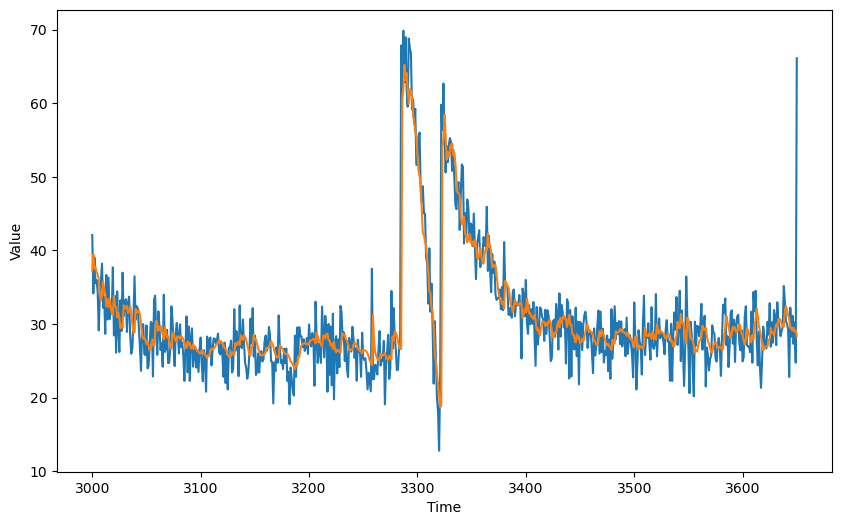

In [12]:

forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [13]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

2.856732

<Figure size 640x480 with 0 Axes>

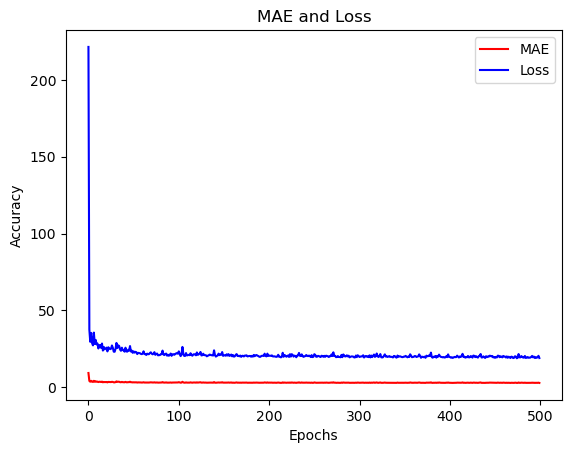

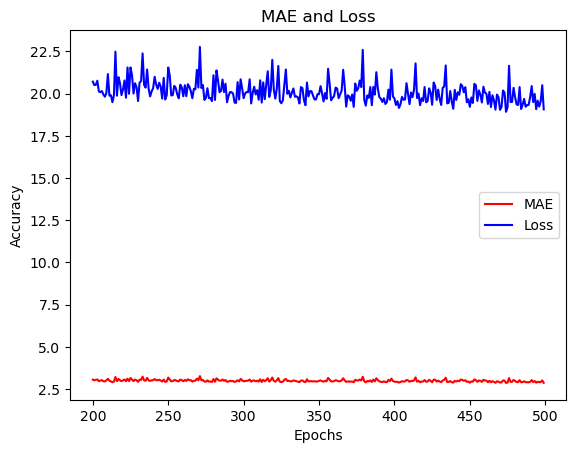

<Figure size 640x480 with 0 Axes>

In [14]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()